## Imports

In [1]:
# !sudo /bin/bash -c "(source /venv/bin/activate; pip install --quiet jupyterlab-vim)"
# !jupyter labextension enable

In [103]:
%load_ext autoreload
%autoreload 2

import arviz as az
import pymc as pm
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as stats
import matplotlib.pyplot as plt
import preliz as pz

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Style notebook

In [ ]:
plt.rcParams['figure.figsize'] = [8, 3]

dir_name = "/aux/code/book.2018.Martin.Bayesian_Analysis_with_Python.2e"

# Thinking probabilistically

# Programming probabilistically

# Hierarchical models

## Hierarchical shifts

In [5]:
cs_data = pd.read_csv(dir_name + '/chemical_shifts_theo_exp.csv')
cs_data["diff"] = cs_data["theo"] - cs_data["exp"]
display(cs_data)

,ID,aa,theo,exp,diff
0,1BM8,ILE,61.18,58.27,2.91
1,1BM8,TYR,56.95,56.18,0.77
2,1BM8,SER,56.35,56.84,-0.49
3,1BM8,ALA,51.96,51.01,0.95
4,1BM8,ARG,56.54,54.64,1.90
...,...,...,...,...,...
1771,1KS9,LYS,55.79,57.51,-1.72
1772,1KS9,ARG,58.91,59.02,-0.11
1773,1KS9,LYS,59.49,58.92,0.57
1774,1KS9,GLU,59.48,58.36,1.12


- ID: code of the protein
- aa: name of the amino acid
- theo: theoretical values of chemical shift
- exp: experimental value

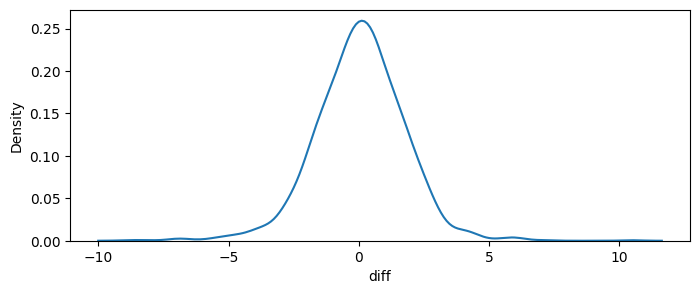

In [6]:
sns.kdeplot(cs_data["diff"]);

In [7]:
vals = cs_data["aa"].unique()
print("aa=", len(vals), vals)

aa= 19 ['ILE' 'TYR' 'SER' 'ALA' 'ARG' 'GLY' 'VAL' 'ASP' 'GLU' 'PHE' 'HIS' 'THR'
 'MET' 'LYS' 'TRP' 'ASN' 'LEU' 'GLN' 'PRO']


In [8]:
diff = cs_data.theo.values - cs_data.exp.values
print("diff=", diff)

# Array of categorical values.
cat_encode = pd.Categorical(cs_data['aa'])
print("cat_encode=", cat_encode)
idx = cat_encode.codes
print("idx=", len(idx), idx)
coords = {"aa": cat_encode.categories}
print("coords=", coords)

diff= [ 2.91  0.77 -0.49 ...  0.57  1.12 -2.48]
cat_encode= ['ILE', 'TYR', 'SER', 'ALA', 'ARG', ..., 'LYS', 'ARG', 'LYS', 'GLU', 'SER']
Length: 1776
Categories (19, object): ['ALA', 'ARG', 'ASN', 'ASP', ..., 'THR', 'TRP', 'TYR', 'VAL']
idx= 1776 [ 8 17 14 ... 10  5 14]
coords= {'aa': Index(['ALA', 'ARG', 'ASN', 'ASP', 'GLN', 'GLU', 'GLY', 'HIS', 'ILE', 'LEU',
       'LYS', 'MET', 'PHE', 'PRO', 'SER', 'THR', 'TRP', 'TYR', 'VAL'],
      dtype='object')}


## Hierarchical shifts

### Non-hierarchical model

In [9]:
# Non-hierarchical model.
with pm.Model(coords=coords) as cs_nh:
    # One separate prior for each group.
    mu = pm.Normal('mu', mu=0, sigma=10, dims="aa")
    sigma = pm.HalfNormal("sigma", sigma=10, dims="aa")
    # Likelihood.
    y = pm.Normal("y", mu=mu[idx], sigma=sigma[idx], observed=diff)
    idata_cs_nh = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


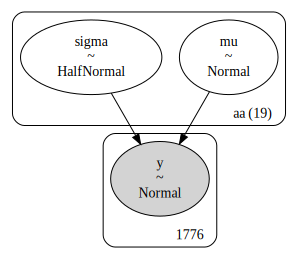

In [10]:
pm.model_to_graphviz(cs_nh)

In [11]:
idata_cs_nh

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data

### Hierarchical model

- Assume that there are 2 hyperpriors one for mean and one for std dev of mu
- We assume that \sigma is without hyperpriors
    - \sigma is the same for all the groups

In [12]:
with pm.Model(coords=coords) as cs_h:
    # Hyper-priors.
    mu_mu = pm.Normal("mu_mu", mu=0, sigma=10)
    mu_sigma = pm.HalfNormal("mu_sigma", sigma=10)
    
    # Priors.
    mu = pm.Normal("mu", mu=mu_mu, sigma=mu_sigma, dims="aa")
    sigma = pm.HalfNormal("sigma", sigma=10, dims="aa")
    
    # Likelihood (same as before).
    y = pm.Normal("y", mu=mu[idx], sigma=sigma[idx], observed=diff)
    idata_cs_h = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_mu, mu_sigma, mu, sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


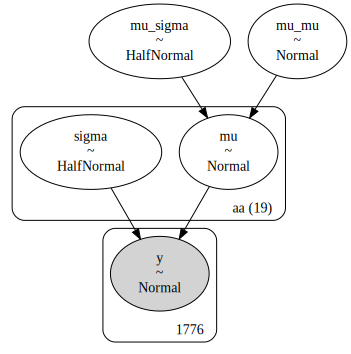

In [13]:
pm.model_to_graphviz(cs_h)

In [14]:
idata_cs_h

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data

### Comparison

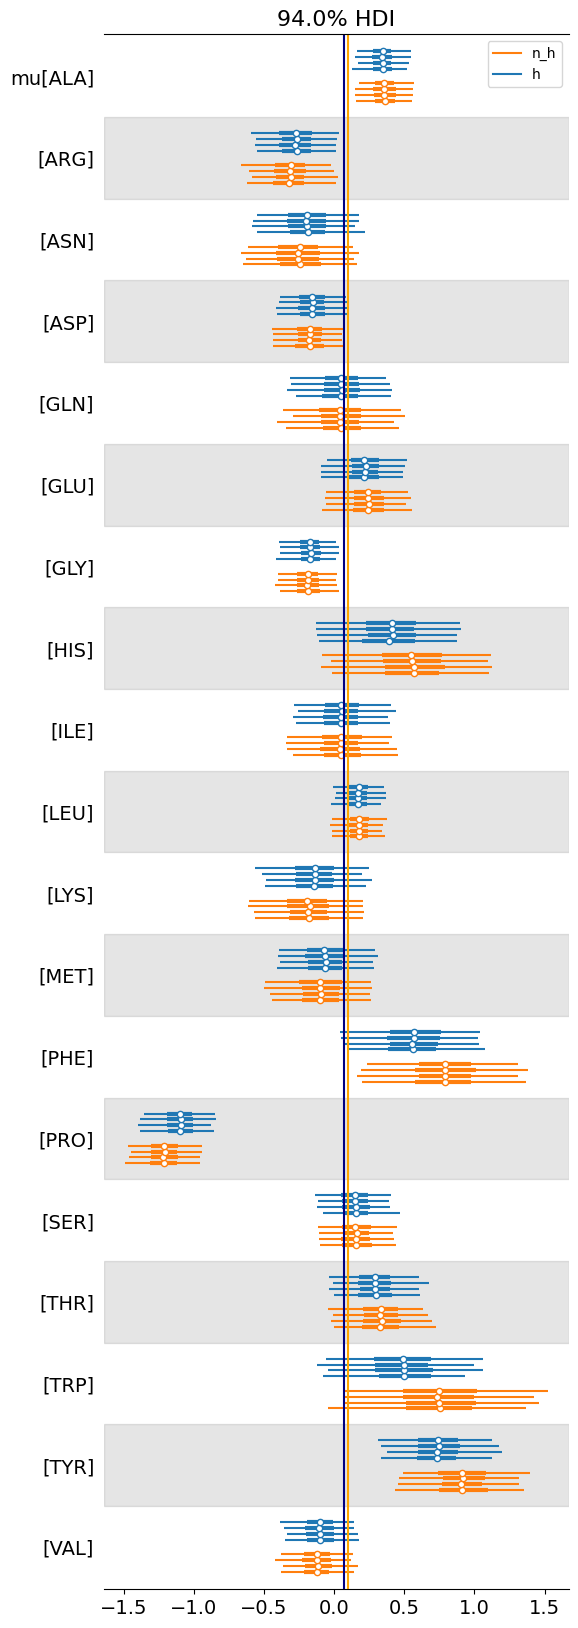

In [24]:
# We have two models and we want to compare the estimates.
# - There are 20 groups and each model has 4 estimates.
# - We plot the 94% credible intervals.
# - The vertical line is the global mean according to the hierarchical model.
# - The blue (hierarchical) means are pulled towards the mean, wrt the orange (non-hierarchical) ones.
axes = az.plot_forest([idata_cs_h, idata_cs_nh],
                      model_names=['h', 'n_h'],
                      var_names='mu',
                      combined=False,
                      colors='cycle')

y_lims = axes[0].get_ylim()
axes[0].vlines(idata_cs_h.posterior['mu_mu'].mean(), *y_lims, color='navy')
axes[0].vlines(idata_cs_nh.posterior['mu'].mean(), *y_lims, color='orange')

## Water quality

In [32]:
def get_water_data(G_samples):
    # 3 different parts of the city.
    # N_samples is the number of samples for each group.
    N_samples = [30, 30, 30]
    
    # For each sample.
    group_idx = np.repeat(np.arange(len(N_samples)), N_samples)
    print("group_idx=", group_idx)
    
    # For each group.
    data = []
    for i in range(0, len(N_samples)):
        # Create a vector with 1 for good samples, and 0 for bad sample for each group.
        vals = np.repeat([1, 0], [G_samples[i], N_samples[i] - G_samples[i]])
        data.extend(vals)
        
    print("data=", data)
    return data

In [33]:
# Good samples per group.
G_samples = [18, 18, 18]
data = get_water_data(G_samples)

group_idx= [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]
data= [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [34]:
def fit(data):
    with pm.Model() as model_h:
        # Hyperpriors.
        mu = pm.Beta("mu", 1.0, 1.0)
        nu = pm.HalfNormal("nu", 10)
        # Priors.
        theta = pm.Beta("theta",
                        alpha=mu * nu,
                        beta=(1.0 - mu) * nu,
                        shape=len(N_samples))
        # Model.
        y = pm.Bernoulli('y', p=theta[group_idx], observed=data)
        idata_h = pm.sample(2000)
    return idata_h

In [35]:
idata_h = fit(data)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, nu, theta]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 2 seconds.


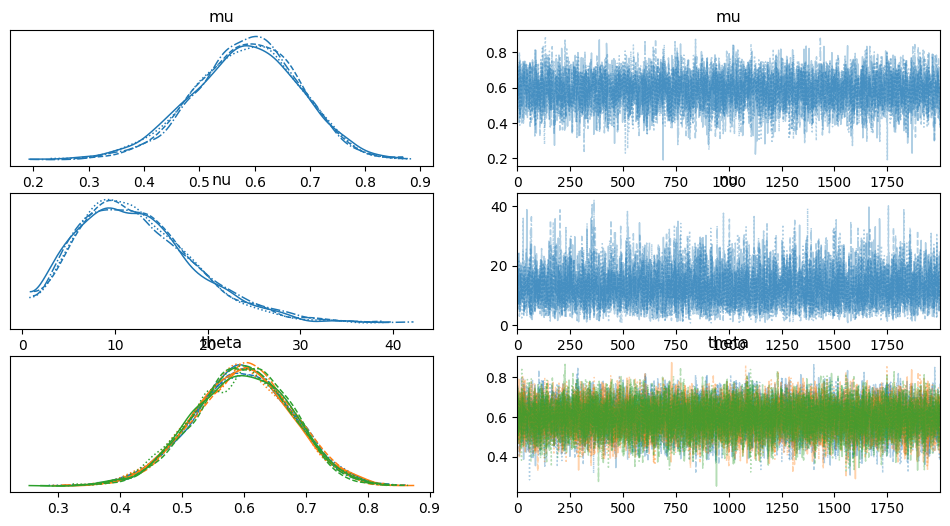

In [27]:
az.plot_trace(idata_h);

In [28]:
az.summary(idata_h, kind="stats")

,mean,sd,hdi_3%,hdi_97%
mu,0.584,0.096,0.410,0.769
nu,12.406,6.290,1.502,23.638
theta[0],0.597,0.080,0.443,0.741
theta[1],0.597,0.079,0.450,0.746
theta[2],0.596,0.079,0.442,0.733


## Shrinkage


In [65]:
G_samples_array = [
    [18, 18, 18],
    [3, 3, 3],
    [18, 3, 3]]

idata = [None, None, None]
for i, G_samples in enumerate(G_samples_array):
    data = get_water_data(G_samples)
    idata[i] = fit(data)
    #idata = az.extract(idata)

group_idx= [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]
data= [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, nu, theta]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 2 seconds.


group_idx= [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]
data= [1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, nu, theta]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 2 seconds.


group_idx= [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]
data= [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, nu, theta]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 2 seconds.


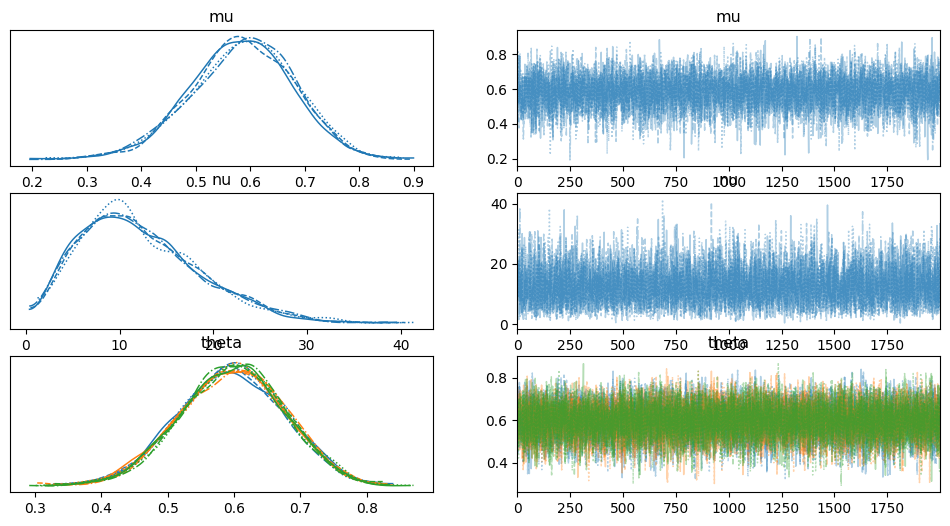

In [66]:
az.plot_trace(idata[0]);
#az.summary(idata, kind="stats")

In [52]:
idata

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data

In [80]:
data = []
for i in range(3):
    data_tmp = az.summary(idata[i]["posterior"]["theta"], kind="stats")["mean"].values
    print(G_samples_array[i], ":", data_tmp)
    data.append(data_tmp)

[18, 18, 18] : [0.595 0.597 0.598]
[3, 3, 3] : [0.114 0.113 0.113]
[18, 3, 3] : [0.552 0.128 0.126]


In [81]:
df = pd.DataFrame(
    data,
    index=map(str, G_samples_array))
df

,0,1,2
"[18, 18, 18]",0.595,0.597,0.598
"[3, 3, 3]",0.114,0.113,0.113
"[18, 3, 3]",0.552,0.128,0.126


<Axes: >

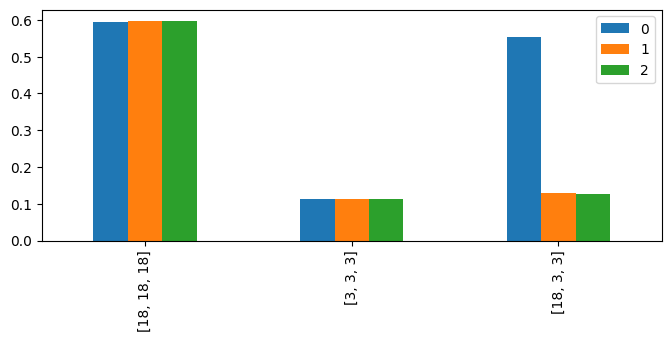

In [78]:
df.plot(kind="bar")

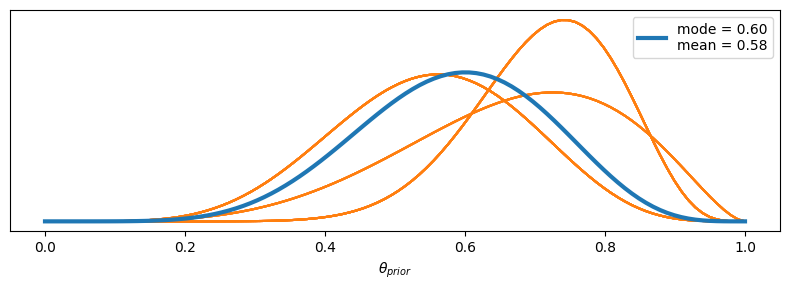

In [30]:
# Plot the hyper priors.
x = np.linspace(0, 1, 100)

# Pick 10 priors.
n_priors = 100
for i in np.random.randint(0, len(idata_h), size=n_priors):
    u = idata_h.posterior['mu'][0][i]
    n = idata_h.posterior['nu'][0][i]
    pdf = stats.beta(u * n, (1.0 - u) * n).pdf(x)
    plt.plot(x, pdf, 'C1', alpha=0.2)

# Plot the mean prior.
u_mean = idata_h.posterior['mu'].mean()
n_mean = idata_h.posterior['nu'].mean()
dist = stats.beta(u_mean * n_mean, (1.0 - u_mean) * n_mean)
pdf = dist.pdf(x)

mode = x[np.argmax(pdf)]
mean = dist.moment(1)

plt.plot(x, pdf, lw=3, label=f'mode = {mode:.2f}\nmean = {mean:.2f}')
plt.yticks([])
plt.legend()
plt.xlabel('$θ_{prior}$')
plt.tight_layout()

## Hierarchies all the way up

In [85]:
football = pd.read_csv(dir_name + "/data/football_players.csv", dtype={'position':'category'})
football

,name,position,goals,shots
0,Aaron Connolly,FW,5,59
1,Aaron Cresswell,DF,4,69
2,Aaron Hunt,MF,3,30
3,Aaron Lennon,MF,1,5
4,Aaron Leya Iseka,FW,10,76
...,...,...,...,...
2677,Óscar Mingueza,DF,2,12
2678,Óscar Plano,MF,12,124
2679,Óscar Rodríguez,MF,13,133
2680,Óscar Trejo,MF,1,20


In [95]:
football["ratio"] = football["goals"] / football["shots"]
football.groupby("position")["ratio"].mean() * 100.0

/tmp/ipykernel_5108/3383593085.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  football.groupby("position")["ratio"].mean() * 100.0


position
DF     7.489539
FW    12.271374
GK     5.158730
MF     7.646762
Name: ratio, dtype: float64

In [98]:
football.groupby("position")["shots"].sum()

/tmp/ipykernel_5108/1567997287.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  football.groupby("position")["shots"].sum()


position
DF    27520
FW    67726
GK       69
MF    52832
Name: shots, dtype: int64

In [99]:
football.groupby("position")["goals"].sum()

/tmp/ipykernel_5108/3780690635.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  football.groupby("position")["goals"].sum()


position
DF    2259
FW    9393
GK       3
MF    4597
Name: goals, dtype: int64

In [90]:
pos_idx = football.position.cat.codes.values
print("pos_idx=", pos_idx)
pos_codes = football.position.cat.categories
print("pos_codes=", pos_codes)
n_pos = pos_codes.size
print("n_pos=", n_pos)
n_players = football.index.size
print("n_players=", n_players)

pos_idx= [1 0 3 ... 3 3 0]
pos_codes= Index(['DF', 'FW', 'GK', 'MF'], dtype='object')
n_pos= 4
n_players= 2682


In [101]:
coords = {"pos": pos_codes}
with pm.Model(coords=coords) as model_football:
    # - Hyper params.
    # Weakly informative prior since we know that 0.5 is very high value.
    # This is choosen to have 95% of mass between 0 and 0.5
    mu = pm.Beta("mu", 1.7, 5.8)
    nu = pm.Gamma("nu", mu=125, sigma=50)
    # - Params for positions.
    mu_p = pm.Beta("mu_p", mu=mu, nu=nu, dims="pos")
    nu_p = pm.Gamma("nu_p", mu=125, sigma=50, dims="pos")
    # - Params for players.
    theta = pm.Beta("theta", mu=mu_p[pos_idx], nu=nu_p[pos_idx])
    gs = pm.Binomial("gs", n=football.shots.values, p=theta, observed=football.goals.values)
    #
    idata_football = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, nu, mu_p, nu_p, theta]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 29 seconds.
There were 406 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


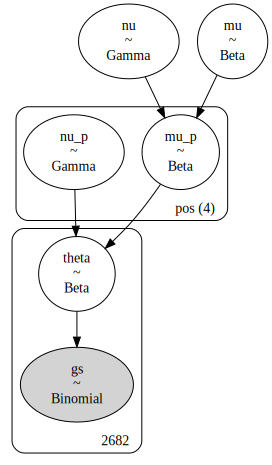

In [110]:
graph = pm.model_to_graphviz(model_football)
graph

In [105]:
pz.Beta(1.7, 5.8).plot_interactive()

interactive(children=(FloatSlider(value=1.7, description='alpha (0, inf)', max=12.0, min=2.220446049250313e-16…

In [104]:
pz.Gamma(mu=125, sigma=50).plot_interactive()

interactive(children=(FloatSlider(value=125.0, description='mu (0, inf)', max=1100.0, min=2.220446049250313e-1…

In [113]:
idata_football

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data

Text(0.5, 1.0, 'Messi mean')

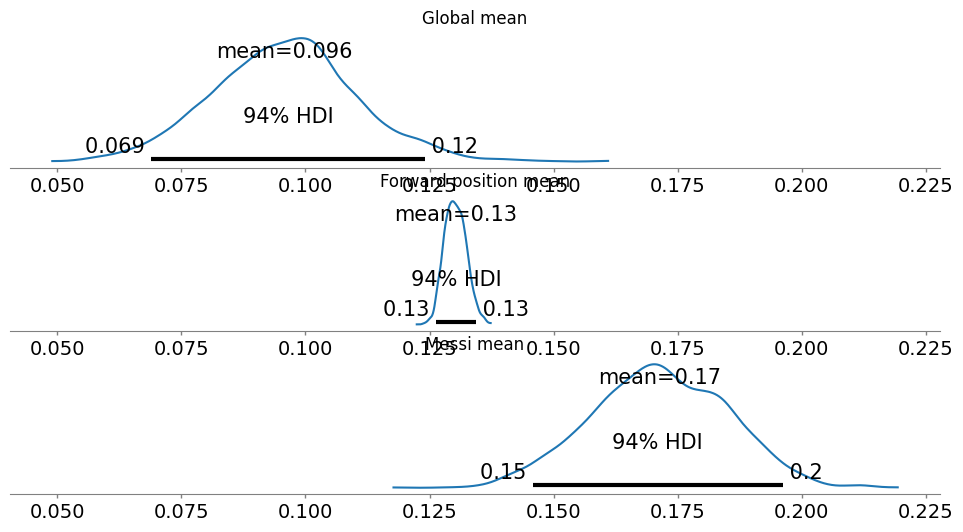

In [114]:
# Plot the posterior mean for several scenarios.
_, ax = plt.subplots(3, 1, figsize=(12, 6), sharex=True)

az.plot_posterior(idata_football, var_names='mu', ax=ax[0])
ax[0].set_title(r"Global mean")

az.plot_posterior(idata_football.posterior.sel(pos="FW"), var_names='mu_p', ax=ax[1])
ax[1].set_title(r"Forward position mean")

az.plot_posterior(idata_football.posterior.sel(theta_dim_0=1457), var_names='theta', ax=ax[2])
ax[2].set_title(r"Messi mean")

array([<Axes: title={'center': '94.0% HDI'}>], dtype=object)

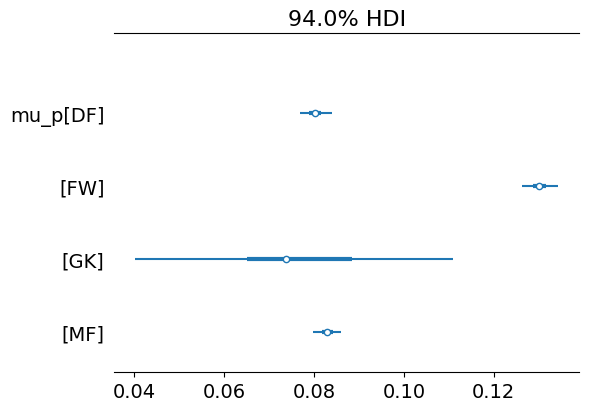

In [116]:
# Plot the posterior distribution by position.
az.plot_forest(idata_football, var_names=['mu_p'], combined=True);